In [1]:
import sklearn
import numpy as np
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from funcs.utils import *
from funcs.explainNumpy import *
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from funcs.DIMV import DIMVImputation
from funcs.miss_forest import mf

missing_rate = 0.4
nruns = 1
ouput_name = 'XGBRegressor_mnist_rate04'  

chosen_model = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

In [2]:
cols_index = ['Xgb on missing data','Mean Imputation','MICE','DIMV','missForest','SOFT-IMPUTE','GAIN']

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize((8,8)),  # Resizing to 8x8 to match input size of 64 (8x8)
                                transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../../data', train=True,  transform=transform, download=False)
test_dataset = datasets.MNIST(root='../../data', train=False, transform=transform,  download=False)

X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

X_test = np.array([test_dataset[i][0].numpy() for i in range(len(test_dataset))])
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

In [4]:
X_train = X_train.reshape((-1,64))
X_test = X_test.reshape((-1,64))

In [5]:
X_train.shape

(60000, 64)

In [6]:
    scaler = StandardScaler()
    scaler.fit(X_train)
    # X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    # X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

    y_train, y_test = y_train.reshape((-1,1)), y_test.reshape((-1,1))
    # scaler_y = StandardScaler()
    # scaler_y.fit(y_train)
    # y_train = pd.DataFrame(scaler_y.transform(y_train))
    # y_test = pd.DataFrame(scaler_y.transform(y_test))    
    X_train_star = generate_missing_data(X_train, rate=missing_rate)
    X_test_star = generate_missing_data(X_test, rate=missing_rate) 

# Generate missing data, impute, and use SHAP to explain

In [7]:
    ori_model = chosen_model
    ori_model.fit(X_train, y_train)
    explainer_ori = shap.Explainer(ori_model, X_test)
    shap_values_ori = explainer_ori(X_test)  
    ypred_ori = ori_model.predict(X_test)

100%|===================| 99899/100000 [09:56<00:00]        

In [8]:
    xm_model = chosen_model #xgboost directly on missing data
    xm_model.fit(X_train_star, y_train)
    explainer_xm = shap.Explainer(xm_model, X_test_star)
    shap_values_xm = explainer_ori(X_test_star)      
    ypred_xm = xm_model.predict(X_test_star)

100%|===================| 99923/100000 [11:25<00:00]        

In [9]:
    # impute X using mean imputation 
    X_train_mi = np.where(np.isnan(X_train_star), np.nanmean(X_train_star, axis=0), X_train_star)
    X_test_mi = np.where(np.isnan(X_test_star), np.nanmean(X_train_star, axis=0), X_test_star)
    model_mi = chosen_model
    model_mi.fit(X_train_mi, y_train)
    explainer_mi = shap.Explainer(model_mi, X_test_mi)
    shap_values_mi = explainer_mi(X_test_mi)
    ypred_mi = model_mi.predict(X_test_mi)

100%|===================| 99851/100000 [08:50<00:00]        

In [10]:
    # MICE imputation 
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputer.fit(X_train_star)
    X_train_mice = imputer.transform(X_train_star)
    X_test_mice = imputer.transform(X_test_star)
    model_mice = chosen_model
    model_mice.fit(X_train_mice, y_train)
    explainer_mice = shap.Explainer(model_mice, X_test_mice)
    shap_values_mice = explainer_mice(X_test_mice)
    ypred_mice = model_mice.predict(X_test_mice)

C:\Users\thung\.conda\envs\mtime\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
100%|===================| 99898/100000 [09:37<00:00]        

In [11]:
    # DIMV imputation 
    imputer = DIMVImputation()
    X_train_star_np, X_test_star_np = np.array(X_train_star), np.array(X_test_star)
    imputer.fit(X_train_star_np, initializing=False)
    imputer.cross_validate(train_percent=10, alphas=[0.1, 1.0, 10.0]) 

Start Cross Validation with alphas = [0.1, 1.0, 10.0] and 10 % of training set
Running Cross Validation, alpha=0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [08:51<00:00,  8.31s/it]


Running Cross Validation, alpha=1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [08:50<00:00,  8.28s/it]


Running Cross Validation, alpha=10.0


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [08:52<00:00,  8.33s/it]

Validation result: best alpha 0.1, best score 0.08755816257386691, scores {0.1: 0.08755816257386691, 1.0: 0.10108919851432854, 10.0: 0.1310686334169784}


0.1

In [12]:
    X_train_dimv = imputer.transform(X_train_star_np,cross_validation=False)
    X_test_dimv = imputer.transform(X_test_star_np,cross_validation=False)

Value alpha used in for transforming is: 0.1


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [7:08:02<00:00, 401.29s/it]


Value alpha used in for transforming is: 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [09:03<00:00,  8.50s/it]


In [13]:
    model_dimv = chosen_model
    model_dimv.fit(X_train_dimv, y_train)
    explainer_dimv = shap.Explainer(model_dimv, X_test_dimv)
    shap_values_dimv = explainer_dimv(X_test_dimv)
    ypred_dimv = model_dimv.predict(X_test_dimv)

100%|===================| 99979/100000 [09:55<00:00]        

In [14]:
    # MissForest
    # mf = MissForest().fit_transform
    X_train_mf = mf(np.array(X_train_star))
    X_test_mf = mf(np.vstack((X_train_star, X_test_star)))[-len(X_test_star):]
    model_mf = chosen_model
    model_mf.fit(X_train_mf, y_train)
    explainer_mf = shap.Explainer(model_mf, X_test_mf)
    shap_values_mf = explainer_mf(X_test_mf)
    ypred_mf = model_mf.predict(X_test_mf)

loss 0.09903823
loss 0.011709516
loss 0.0070990426
number of runs used by missForest: 3
loss: 0.0070990426
loss 0.099618435
loss 0.011479573
loss 0.0069966097
number of runs used by missForest: 3
loss: 0.0069966097


100%|===================| 99983/100000 [09:31<00:00]        

In [15]:
    # SoftImpute
    X_train_soft = SoftImpute(verbose = False).fit_transform(X_train_star)
    X_test_soft = SoftImpute(verbose = False).fit_transform(np.vstack((X_train_star, X_test_star)))[-len(X_test_star):]
    model_soft = chosen_model
    model_soft.fit(X_train_soft, y_train)
    explainer_soft = shap.Explainer(model_soft, X_test_soft)
    shap_values_soft = explainer_soft(X_test_soft)
    ypred_soft = model_soft.predict(X_test_soft)

100%|===================| 99961/100000 [11:09<00:00]        

In [16]:
    # GAIN imputation 
    from funcs.explain import impute_gain
    # from funcs.GAIN.utils import binary_sampler, normalization, renormalization, rounding
    imputed_gain = impute_gain(np.vstack((X_train_star, X_test_star)))
    X_train_gain = imputed_gain[:len(X_train_star)]
    X_test_gain = imputed_gain[len(X_train_star):]
    model_gain = chosen_model
    model_gain.fit(X_train_gain, y_train)
    explainer_gain = shap.Explainer(model_gain, X_test_gain)
    shap_values_gain = explainer_gain(X_test_gain)
    ypred_gain = model_gain.predict(X_test_gain)


Instructions for updating:
non-resource variables are not supported in the long term



100%|===================| 99906/100000 [08:53<00:00]        

In [17]:
    mse_imputation = lambda X_test_imputed: np.mean((np.array(X_test_imputed)-np.array(X_test))**2)
    mse_imputation_all = np.array([mse_imputation(X_test_mi), mse_imputation(X_test_mice),
                        mse_imputation(X_test_dimv), mse_imputation(X_test_mf),
                        mse_imputation(X_test_soft), mse_imputation(X_test_gain)])

    mse_shap = lambda computed_shap_values: np.mean((computed_shap_values - shap_values_ori.values)**2)
    mse_shap_all = np.array([mse_shap(shap_values_xm.values),mse_shap(shap_values_mi.values), mse_shap(shap_values_mice.values),
                        mse_shap(shap_values_dimv.values), mse_shap(shap_values_mf.values), mse_shap(shap_values_soft.values),
                            mse_shap(shap_values_gain.values)])

    mse_ypred = lambda ypred_method: np.mean((ypred_ori-ypred_method)**2)
    mse_ypred_all = np.array([mse_ypred(ypred_xm), mse_ypred(ypred_mi), mse_ypred(ypred_mice),
                              mse_ypred(ypred_dimv), mse_ypred(ypred_mf), mse_ypred(ypred_soft), mse_ypred(ypred_gain)])

In [18]:
def get_average_shap_vals(results, j, nruns):
    # get the average shap values from all runs for each imputation method or the original 
    current = results[0][0][j]
    for i in range(1, nruns):
        current.values += results[i][0][j].values
        current.base_values += results[i][0][j].base_values
        current.data += results[i][0][j].data  
    current.values = current.values/nruns
    current.base_values = current.base_values/nruns
    current.data = current.data/nruns
    return current

In [19]:
shap_values_ori = get_average_shap_vals(results, j = 0, nruns= nruns)
shap_values_xm = get_average_shap_vals(results, j = 1, nruns= nruns)
shap_values_mi = get_average_shap_vals(results, j = 2, nruns = nruns)
shap_values_mice = get_average_shap_vals(results, j = 3, nruns= nruns)
shap_values_dimv = get_average_shap_vals(results, j = 4, nruns= nruns)
shap_values_mf = get_average_shap_vals(results, j = 5, nruns= nruns)
shap_values_soft = get_average_shap_vals(results, j = 6, nruns= nruns)
shap_values_gain = get_average_shap_vals(results, j = 7, nruns= nruns)

NameError: name 'results' is not defined

In [20]:
dfplot = pd.DataFrame({'MSE':np.hstack((0,mse_imputation_all)), 'MSE Shap': mse_shap_all}, index = cols_index)
dfplot.round(3).T

,Xgb on missing data,Mean Imputation,MICE,DIMV,missForest,SOFT-IMPUTE,GAIN
MSE,0.000,0.009,0.004,0.003,0.002,0.005,0.008
MSE Shap,0.074,0.034,0.020,0.018,0.011,0.023,0.034


In [21]:
dfplot.round(3).T.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & Xgb on missing data & Mean Imputation & MICE & DIMV & missForest & SOFT-IMPUTE & GAIN \\\\\n\\midrule\nMSE & 0.000000 & 0.009000 & 0.004000 & 0.003000 & 0.002000 & 0.005000 & 0.008000 \\\\\nMSE Shap & 0.074000 & 0.034000 & 0.020000 & 0.018000 & 0.011000 & 0.023000 & 0.034000 \\\\\n\\bottomrule\n\\end{tabular}\n'

imputation MSE versus Shapley MSE


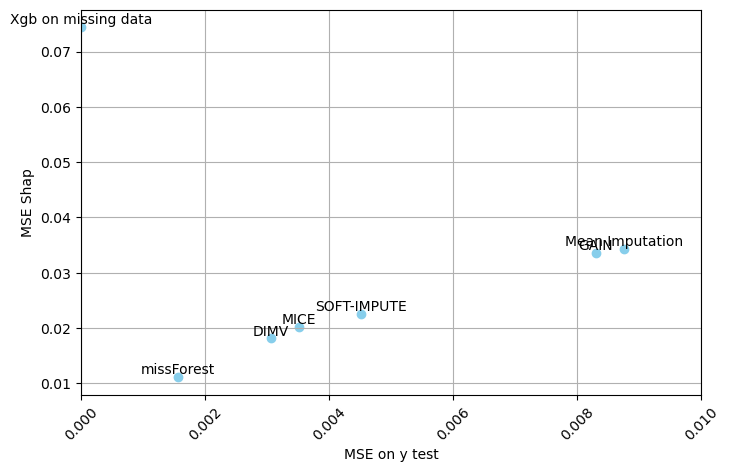

In [22]:
print('imputation MSE versus Shapley MSE')
plt.figure(figsize=(8, 5))
plt.scatter(dfplot['MSE'],dfplot['MSE Shap'], color='skyblue')
for i, row in dfplot.iterrows():
    plt.text(row['MSE'],row['MSE Shap'], row.name, ha='center', va='bottom')
plt.ylabel('MSE Shap')
plt.xlabel('MSE on y test')
plt.xlim(0.00, 0.01)
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid for better visualization
plt.savefig('results/'+ ouput_name+'imputation_mse_vs_shap_mse'+'.png',bbox_inches='tight')
plt.show()